In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [123]:
def add_confidence_angle(dataset: xr.Dataset, inplace: bool = False):
    """
    Function to add confidence angle to dataset.

    Confidence Angle = angle[ abs(dVH/dt / mean(dVH/dt)), abs(dVV/dt / mean(dVV/dt)) ]

    Args:
    dataset: Xarray Dataset of sentinel images to add confidence angle to
    inplace: boolean flag to modify original Dataset or return a new Dataset

    Returns:
    dataset: Xarray dataset of sentinel image with confidence interval in 
    """
    ds_amp = s1_dB_to_power(dataset).copy()
    ds_amp['deltaVH_amp'] = ds_amp['s1'].sel(band = 'VH').diff(1)
    ds_amp['deltaVV_amp'] = ds_amp['s1'].sel(band = 'VV').diff(1)

    ds_amp['deltaVH_norm'] = np.abs(ds_amp['deltaVH_amp'] / ds_amp['deltaVH_amp'].mean())
    ds_amp['deltaVV_norm'] = np.abs(ds_amp['deltaVV_amp'] / ds_amp['deltaVV_amp'].mean())

    ds_amp['confidence'] = (ds_amp['deltaVH_norm'].dims, np.angle(ds_amp['deltaVV_norm'].values + ds_amp['deltaVH_norm'].values * 1j))

    dataset['confidence'] = np.sin(ds_amp['confidence'].mean('time')) #* (1 - ds_amp['fcf']) #  * np.sin(ds_amp['s1'].sel(band = 'inc').mean('time'))

    if not inplace:
        return dataset

def confidence_new(ds):
    ds_amp = s1_dB_to_power(ds).copy()
    ds_amp['deltaVH_amp'] = ds_amp['s1'].sel(band = 'VH').diff(1)
    ds_amp['deltaVV_amp'] = ds_amp['s1'].sel(band = 'VV').diff(1)

    ds_amp['deltaVH_norm'] = np.abs(ds_amp['deltaVH_amp'] / ds_amp['deltaVH_amp'].mean())
    ds_amp['deltaVV_norm'] = np.abs(ds_amp['deltaVV_amp'] / ds_amp['deltaVV_amp'].mean())
    ds_amp['deltaGamma_norm'] = np.abs(ds_amp['deltaGamma'] / ds_amp['deltaGamma'].mean())

    ds_amp['confidence_notree'] = (ds_amp['deltaVH_norm'].dims, np.angle(ds_amp['deltaVV_norm'].values + ds_amp['deltaVH_norm'].values * 1j))
    ds_amp['confidence_tree'] = (ds_amp['s1'].sel(band = 'VV') - ds_amp['s1'].sel(band = 'VV').isel(time = slice(None, len(np.unique(ds.relative_orbit)))).mean()) / ds_amp['s1'].sel(band = 'VV').mean()

    ds['confidence'] = xr.where( ds['fcf'] < 0.5, ds_amp['confidence_notree'].mean('time'), ds_amp['confidence_tree'].mean('time'))
    return ds

In [124]:
dss = [xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data').expanduser().glob('*.nc')]

In [ ]:
ds = dss[6]
fig, axes = plt.subplots(1, 2, figsize = (18, 12))
ds['confidence'].where(~ds['lidar-sd'].isnull()).rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[0])

# dss[0]['fcf'].where(~dss[0]['lidar-sd'].isnull()).plot(ax = axes[1])
np.abs(ds['lidar-sd'] - ds['snow_depth'].sel(time = ds.attrs['lidar-flight-time'], method = 'nearest')).rolling(x = 4, y = 4, min_periods = 1).mean().plot(ax = axes[1], vmax = 2)

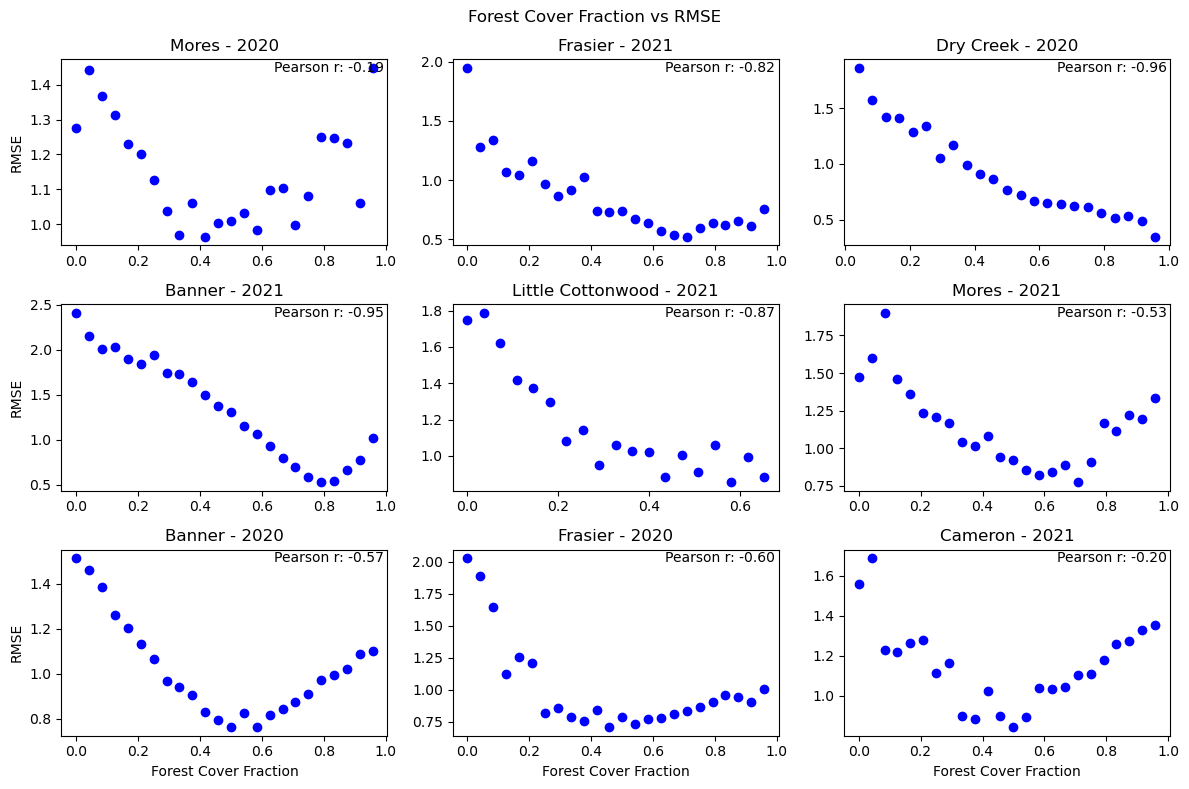

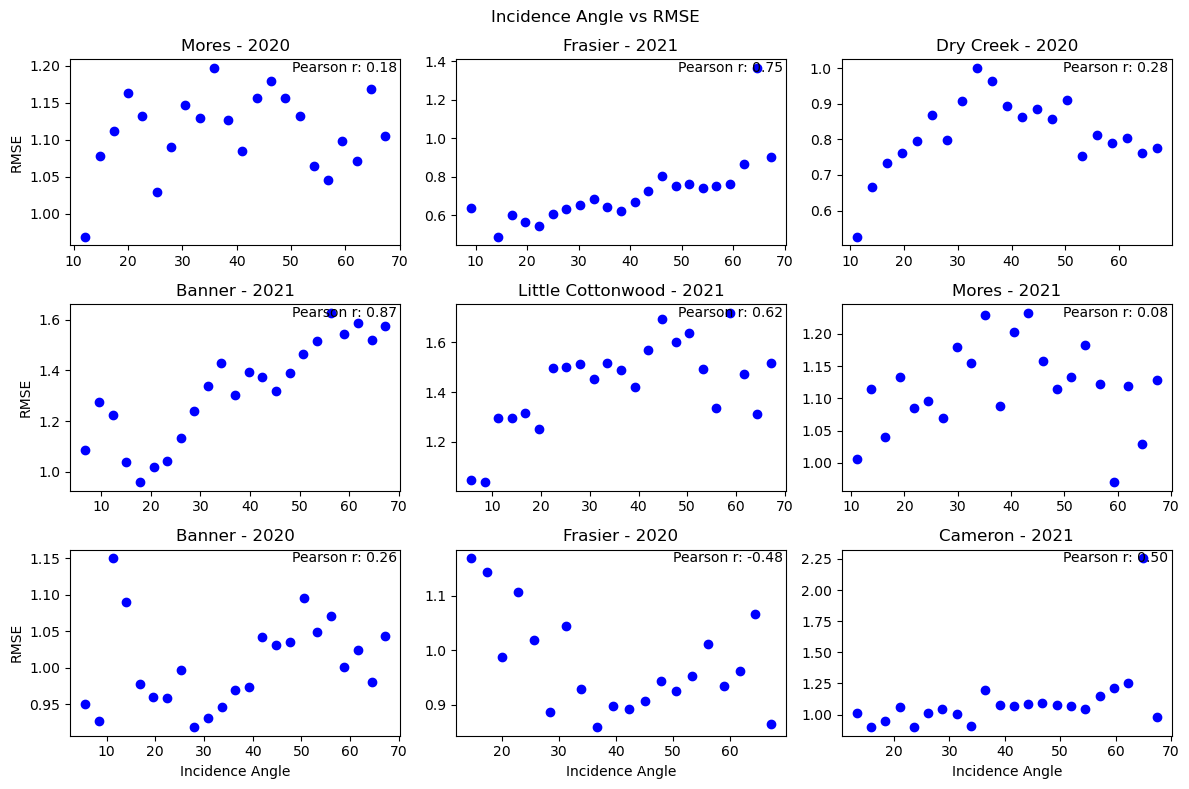

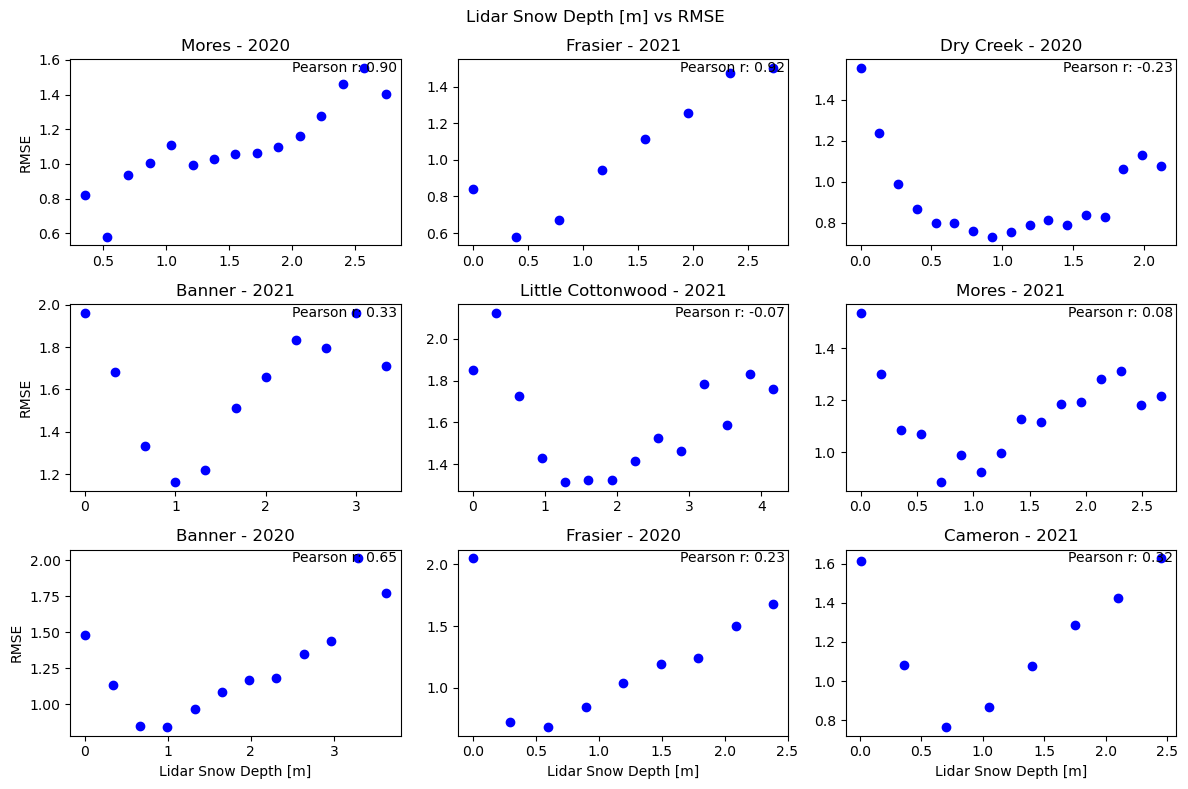

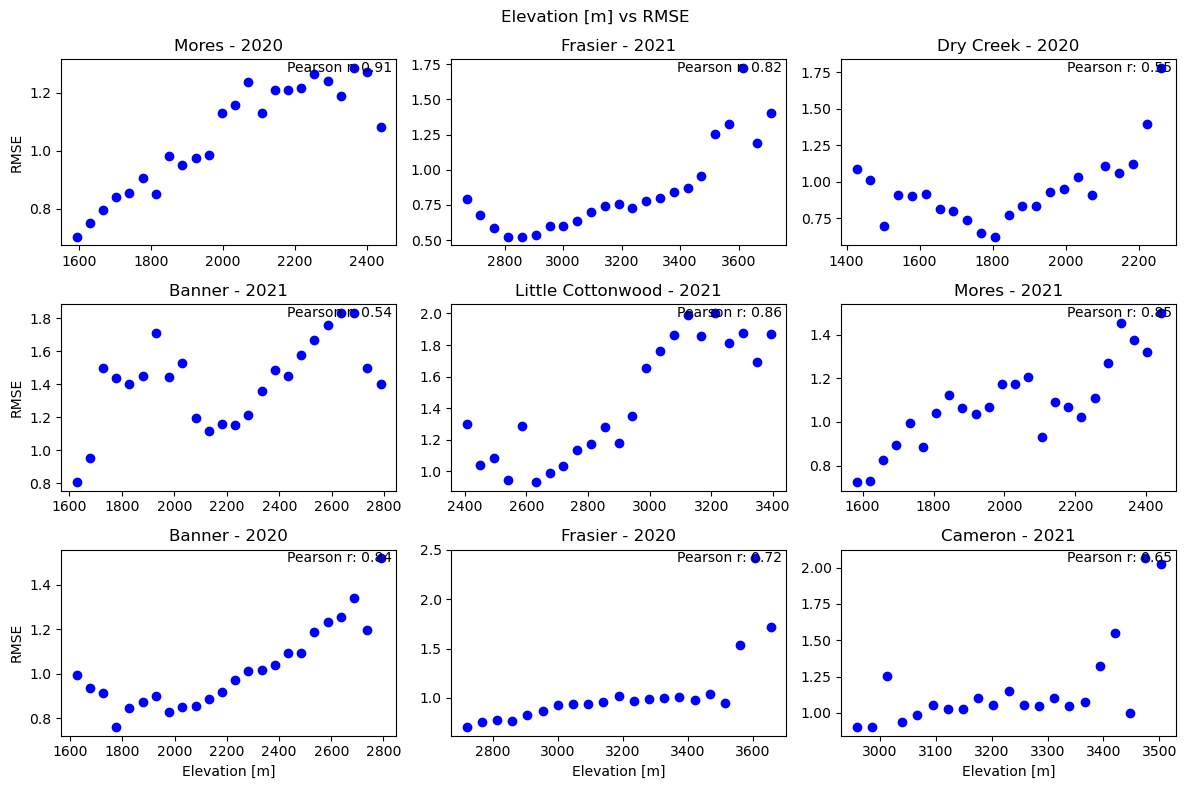

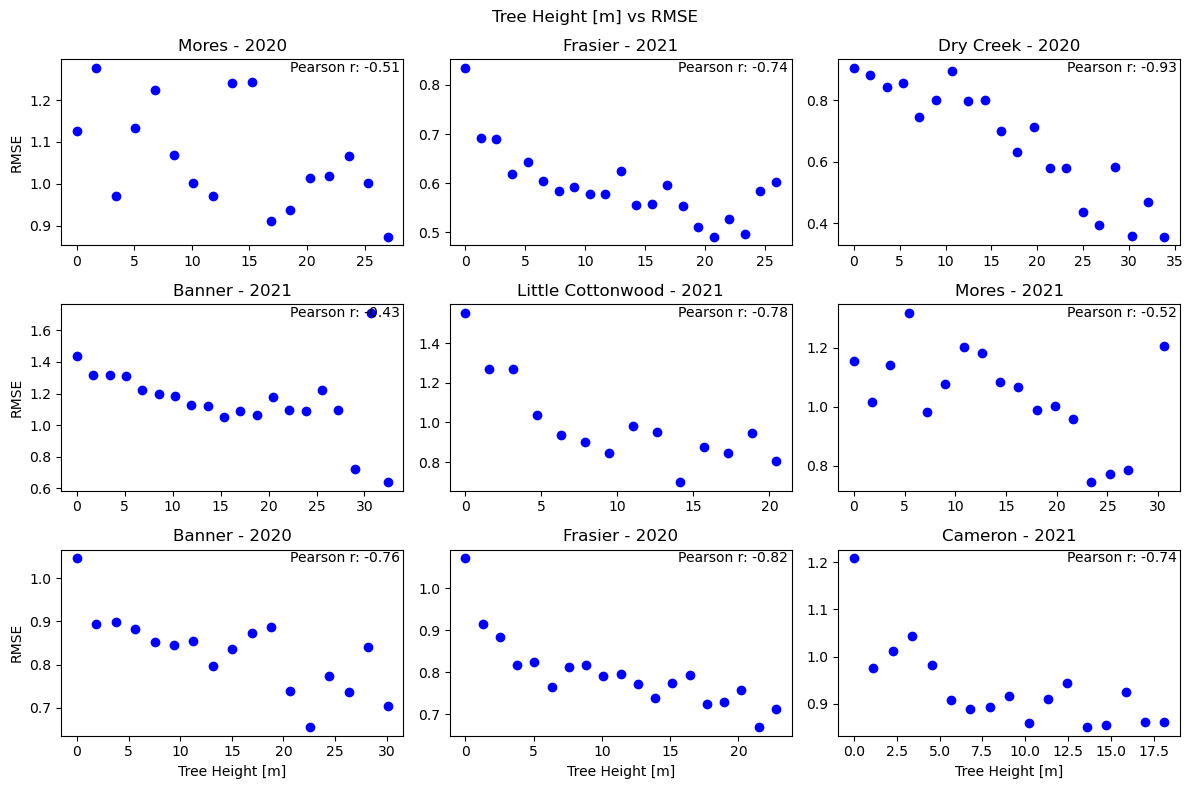

In [141]:
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    fig, axes = plt.subplots(3, 3, figsize = (12,8))
    for ds, ax in zip(dss, axes.ravel()):

        ds = add_confidence_angle(ds)

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(time_ds[var].min(), time_ds[var].max(), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 10:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), rmse_result, color = 'blue')
            else:
                ax.scatter(cat.left, rmse_result, color = 'blue')
            xs.append(cat.left)
            ys.append(rmse_result)
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")
        stat, r = pearsonr(xs, ys)

        ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('RMSE')


    plt.suptitle(f'{x_label} vs RMSE')

    plt.tight_layout()

    figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_rmse.png'))

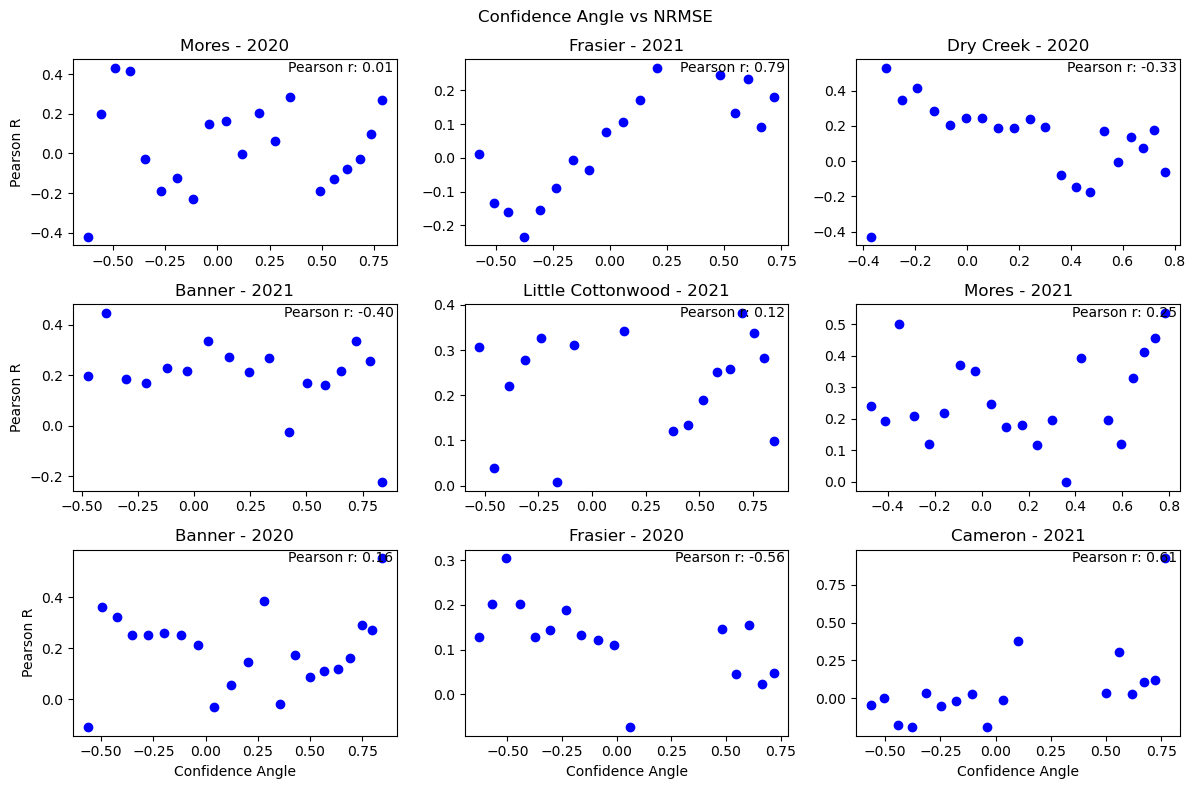

In [97]:
fig, axes = plt.subplots(3, 3, figsize = (12,8))

for ds, ax in zip(dss, axes.ravel()):

    if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
        time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
    else:
        time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
    
    xs = []
    ys = []
    for cat, sub in time_ds.groupby_bins('confidence', np.linspace(ds['confidence'].min(), ds['confidence'].max(), 25)):
        # print(cat)
        x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
        idx = (~np.isnan(x)) & (~np.isnan(y))
        if len(x[idx]) < 10:
            continue
        stat, p = pearsonr(x[idx], y[idx])
        rmse_result = rmse(x[idx], y[idx])
        ax.scatter(np.sin(cat.left), stat, color = 'blue')
        xs.append(cat.left)
        ys.append(stat)
    ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")
    stat, r = pearsonr(xs, ys)

    ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)

for ax in axes[-1, :]:
    ax.set_xlabel('Confidence Angle')
for ax in axes[:, 0]:
    ax.set_ylabel('Pearson R')

plt.suptitle('Confidence Angle vs NRMSE')

plt.tight_layout()

figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/confidence')
plt.savefig(figdir.joinpath('confidence_pearsonr.png'))

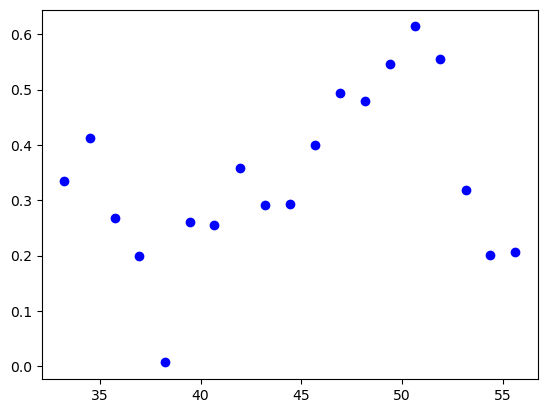

In [177]:
for cat, sub in ds.sel(time = ds.attrs['lidar-flight-time'], method ='nearest').groupby_bins('confidence', np.linspace(ds['confidence'].min(), ds['confidence'].max(), 30)):
    # print(cat)
    x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    if len(x[idx]) < 10:
        continue
    stat, p = pearsonr(x[idx], y[idx])
    rmse_result = rmse(x[idx], y[idx])
    plt.scatter(np.rad2deg(cat.left), stat, color = 'blue')
# plt.ylim(0, 0.4)

Text(0, 0.5, 'RMSE')

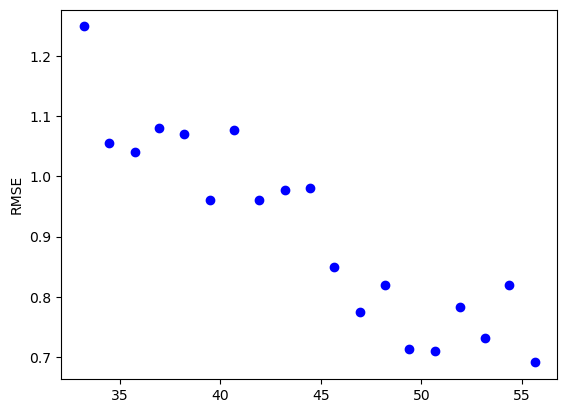

In [178]:
from scipy.stats import pearsonr
for cat, sub in ds.sel(time = ds.attrs['lidar-flight-time'], method ='nearest').groupby_bins('confidence', np.linspace(ds['confidence'].min(), ds['confidence'].max(), 30)):
    # print(cat)
    x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    if len(x[idx]) < 10:
        continue
    stat, p = pearsonr(x[idx], y[idx])
    rmse_result = rmse(x[idx], y[idx])
    plt.scatter(np.rad2deg(cat.left), rmse_result, color = 'blue')
plt.ylabel('RMSE')
# plt.ylim(0.9, 1.4)

Text(0, 0.5, 'RMSE')

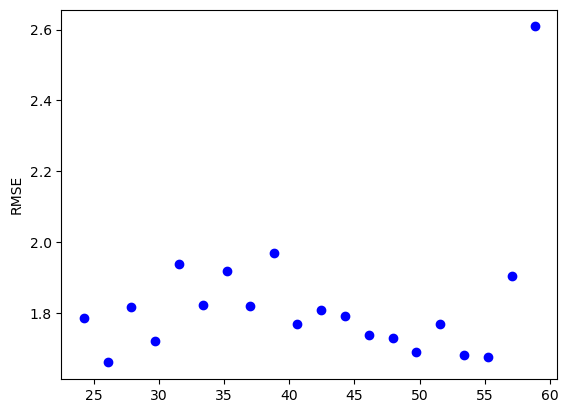

In [171]:
from scipy.stats import pearsonr
for cat, sub in ds.sel(time = ds.attrs['lidar-flight-time'], method ='nearest').groupby_bins('confidence', np.linspace(ds['confidence'].min(), ds['confidence'].max(), 30)):
    # print(cat)
    x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    if len(x[idx]) < 10:
        continue
    stat, p = pearsonr(x[idx], y[idx])
    rmse_result = rmse(x[idx], y[idx])
    plt.scatter(np.rad2deg(cat.left), np.nanmean(x), color = 'blue')
plt.ylabel('RMSE')